In [1]:
using JuMP, Gurobi, CSV, DataFrames,LinearAlgebra, Random, CategoricalArrays,Statistics, Plots

In [2]:
#outcome = CSV.read("outcomes_with_binary.csv")[:,13:18];
#outcome = CSV.read("selectedY.csv") |> DataFrame
#feature = CSV.read("selectedfeatures.csv")[:,2:end] |> DataFrame;
outcome = CSV.read("C:\\Users\\Sofiane\\Documents\\MIT\\Cours\\15.095 ML\\Project\\ML project\\Data\\selectedY.csv") |> DataFrame
feature = CSV.read("C:\\Users\\Sofiane\\Documents\\MIT\\Cours\\15.095 ML\\Project\\ML project\\Data\\selectedfeatures.csv")[:,2:end] |> DataFrame;

In [3]:
time_sentence_to_arrest = outcome[!,:V124];
recidivism = outcome[!,:V127];

In [4]:
recidivism_filtered = map( x -> begin
        if ismissing(x)
            return missing
        elseif x==8
            return missing
        else
            return x
        end
        end,recidivism);

In [5]:
##9998 : not ascertained, vraiment missing
## 9999 : ,ot applicable(mais pas cohérent avec V104 = nombre d ejours depuis année 1900)
#j'ai gardé 9999 as bigger than everything

time_sentence_to_arrest_filtered = map( x -> begin
        if ismissing(x)
            return missing
        elseif x==9998 #x==9999||
            return missing
        else
            return x
        end
    
        end,time_sentence_to_arrest);

In [6]:

for i=1:length(recidivism_filtered)
    if ( ismissing(recidivism_filtered[i])) || (ismissing(time_sentence_to_arrest_filtered[i]))
        #print("hey")
    elseif (recidivism_filtered[i]==1) && (time_sentence_to_arrest_filtered[i]==9999 )
        time_sentence_to_arrest_filtered[i]=missing
    end
end

In [7]:
#Missing values dans time

indexes = .!(ismissing.(time_sentence_to_arrest_filtered));
time_sentence_to_arrest_filtered=time_sentence_to_arrest_filtered[indexes]
recidivism_filtered = recidivism_filtered[indexes]

feature = feature[indexes,:];

In [8]:
# Missing values dans recidivism

indexes = .!(ismissing.(recidivism_filtered))
time_sentence_to_arrest_filtered=time_sentence_to_arrest_filtered[indexes]
recidivism_filtered = recidivism_filtered[indexes]
feature = feature[indexes,:];

In [9]:
recidivism_filtered=Int.(recidivism_filtered)
time_sentence_to_arrest_filtered=Int.(time_sentence_to_arrest_filtered);
recidivism_filtered =Bool.(recidivism_filtered);

valeurs superieures à 1096 (ex 9999, not applicable, les mettre à 1096). Faire gaffe plus tard pour les probas, a ne pas regarder des valeurs trop elevess

In [10]:
# Censor values
time_sentence_to_arrest_filtered = map( x -> begin
        if ismissing(x)
            return missing
        elseif x>=1096 
            return 1096
        else
            return x
        end
    
        end,time_sentence_to_arrest);

In [11]:
#categorize the cogent columns
feature[:,:V6] = CategoricalArray(feature[!,:V6])
feature[:,:V8] = CategoricalArray(feature[!,:V8])
feature[:,:V9] = CategoricalArray(feature[!,:V9])
feature[:,:V10] = CategoricalArray(feature[!,:V10])
feature[:,:V12] = CategoricalArray(feature[!,:V12])
feature[:,:V13] = CategoricalArray(feature[!,:V13])
feature[:,:V15] = CategoricalArray(feature[!,:V15])
feature[:,:V16] = CategoricalArray(feature[!,:V16])
feature[:,:V17] = CategoricalArray(feature[!,:V17])
feature[:,:V20] = CategoricalArray(feature[!,:V20])
feature[:,:V25] = CategoricalArray(feature[!,:V25])
feature[:,:V26] = CategoricalArray(feature[!,:V26])
feature[:,:V27] = CategoricalArray(feature[!,:V27])
feature[:,:V28] = CategoricalArray(feature[!,:V28])
feature[:,:V30] = CategoricalArray(feature[!,:V30])
feature[:,:V31] = CategoricalArray(feature[!,:V31])
feature[:,:V32] = CategoricalArray(feature[!,:V32])
feature[:,:V33] = CategoricalArray(feature[!,:V33])
feature[:,:V34] = CategoricalArray(feature[!,:V34])
feature[:,:V35] = CategoricalArray(feature[!,:V35])
feature[:,:V36] = CategoricalArray(feature[!,:V36])
feature[:,:V37] = CategoricalArray(feature[!,:V37])
feature[:,:V38] = CategoricalArray(feature[!,:V38])
feature[:,:V39] = CategoricalArray(feature[!,:V39])
feature[:,:V40] = CategoricalArray(feature[!,:V40])
feature[:,:V63] = CategoricalArray(feature[!,:V63])
feature[:,:V113] = CategoricalArray(feature[!,:V113])
feature[:,:V114] = CategoricalArray(feature[!,:V114])
feature[:,:V130] = CategoricalArray(feature[!,:V130])
feature[:,:V134] = CategoricalArray(feature[!,:V134])
feature[:,:V136] = CategoricalArray(feature[!,:V136]);

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[11]:1
└ @ Core In[11]:1
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[11]:3
└ @ Core In[11]:3
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[11]:4
└ @ Core In[11]:4
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[11]:5
└ @ Core In[11]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `

In [12]:
##Remove variables too obvious for survival
deletecols!(feature,:V111) #risk score
deletecols!(feature,:V24); #Number of felony arrests during supervision 

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[12]:1
└ @ Core In[12]:1
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[12]:3
└ @ Core In[12]:3


In [13]:
deletecols!(feature,:V25);
deletecols!(feature,:V26);
deletecols!(feature,:V27);
deletecols!(feature,:V28);
deletecols!(feature,:V30);
deletecols!(feature,:V31);
deletecols!(feature,:V32);
deletecols!(feature,:V33);
deletecols!(feature,:V34);
deletecols!(feature,:V35);
deletecols!(feature,:V36);
deletecols!(feature,:V37);
deletecols!(feature,:V38);
deletecols!(feature,:V39);
deletecols!(feature,:V40);
deletecols!(feature,:V41);
deletecols!(feature,:V44);
deletecols!(feature,:V46);
deletecols!(feature,:V47);
deletecols!(feature,:V48);
deletecols!(feature,:V136);

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[13]:1
└ @ Core In[13]:1
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[13]:2
└ @ Core In[13]:2
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[13]:3
└ @ Core In[13]:3
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[13]:4
└ @ Core In[13]:4
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[13]:5
└ @ Core In[13]:5
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[13]:6
└ @ Core In[13]:6
┌ Warning: `deletecols!(df::DataFrame, inds)` is dep

In [14]:


#V17 (type of supervision)
#V20 probation records, jail being imposed
#V 21 : number of officers

#V25 community placement
#V26 status of compliance community placmeent
#C27 alchohol, V28 compliance alcholo
#V30 status drug treamtn,
#V31 drug test, 
#V32 idem
#V33 mental health, 
#34 aussi
#35 36 aussi house arrest
#37 38 day programming
#39 community service
#40 aussi
#41 aussi
#44 aussi
#46 number behaviorual conditions
#47 socre compliance
#48 percentage compiliance
#136 drug outcome

In [15]:
#names(feature)[31:44]

BoundsError: BoundsError: attempt to access 23-element Array{Symbol,1} at index [31:44]

In [16]:
grid_survival = IAI.GridSearch(
    IAI.OptimalTreeSurvivor(
        random_seed=1,
        missingdatamode=:separate_class,
        criterion=:localfulllikelihood,
    ),
    max_depth=1:5,
)
IAI.fit!(grid_survival, feature, recidivism_filtered, time_sentence_to_arrest_filtered,
         validation_criterion=:integratedbrier)
IAI.get_learner(grid_survival)

┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ IAIBase C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\IAIBase\ymcNn\src\precompile.jl:19
Training trees...100%|██████████████████████████████████| Time: 0:00:07
Training trees...100%|██████████████████████████████████| Time: 0:00:07
Training trees...100%|██████████████████████████████████| Time: 0:00:11
Training trees...100%|██████████████████████████████████| Time: 0:00:16
Training trees...100%|██████████████████████████████████| Time: 0:00:28
Training trees...100%|██████████████████████████████████| Time: 0:00:24


Fitted OptimalTreeSurvivor:
  1) Split: V122 < 55.5
    2) Split: V130 in [1,2,3,4,5,6,7,8,9,10,12,13,14,17,18,19,24,29,30,31] or is missing
      3) Split: V122 < 1.5
        4) Split: V8 in [220,300,310,320,500,510,520,530,710,800,830,840,850,860,870,880]
          5) : 83.56% censored, 1709 points, error 562.8
          6) : 92.97% censored, 2105 points, error 437.8
        7) : 69.37% censored, 604 points, error 256
      8) Split: V8 in [100,110,130,200,210,220,400,430,730,800,810,850,860,870,880,998] or is missing
        9) Split: V122 < 0.5
          10) : 81.08% censored, 925 points, error 316.3
          11) : 55.38% censored, 446 points, error 230.4
        12) Split: V113 in [2]
          13) : 36.33% censored, 1068 points, error 542.7
          14) : 56.41% censored, 1927 points, error 1034.4
    15) Split: V130 in [1,2,3,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,31] or is missing
      16) : 98.79% censored, 578 points, error 37.26
      17) : 85.29% censored, 333 points, error 106.5

In [17]:
pred_curves = IAI.predict(grid_survival, feature);

In [18]:

dico =IAI.get_survival_curve_data(pred_curves[1])
times = dico[:times]


930-element Array{Float64,1}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    7.0
    8.0
   10.0
   11.0
   12.0
   13.0
   14.0
    ⋮  
 1076.0
 1077.0
 1078.0
 1079.0
 1081.0
 1086.0
 1089.0
 1090.0
 1092.0
 1093.0
 1094.0
 1096.0

In [19]:
coefs = dico[:coefs]

930-element Array{Float64,1}:
 0.0                   
 1.2226134585291426e-5 
 2.4452269170582852e-5 
 3.667840375587428e-5  
 4.8904538341165704e-5 
 6.113067292645713e-5  
 8.558294209703998e-5  
 9.780907668233141e-5  
 0.00012226134585291426
 0.0001344874804382057 
 0.0001467136150234971 
 0.00015893974960878854
 0.00017116588419407996
 ⋮                     
 0.09415892571399102   
 0.09473462665790856   
 0.09531032760182609   
 0.09588602854574362   
 0.09703743043357868   
 0.09991593515316634   
 0.10164303798491894   
 0.10221873892883647   
 0.10337014081667154   
 0.10394584176058906   
 0.1045215427045066    
 0.10567294459234167   

In [20]:
coefs_full = zeros(1097);
for i=1:length(times)
    coefs_full[Int(times[i]+1)]=coefs[i]
end

for i=2:length(coefs_full)
    if coefs_full[i]==0
        coefs_full[i]=coefs_full[i-1]
    end
end

In [21]:
coefs_full

1097-element Array{Float64,1}:
 0.0                   
 1.2226134585291426e-5 
 2.4452269170582852e-5 
 3.667840375587428e-5  
 4.8904538341165704e-5 
 6.113067292645713e-5  
 6.113067292645713e-5  
 8.558294209703998e-5  
 9.780907668233141e-5  
 9.780907668233141e-5  
 0.00012226134585291426
 0.0001344874804382057 
 0.0001467136150234971 
 ⋮                     
 0.09703743043357868   
 0.09991593515316634   
 0.09991593515316634   
 0.09991593515316634   
 0.10164303798491894   
 0.10221873892883647   
 0.10221873892883647   
 0.10337014081667154   
 0.10394584176058906   
 0.1045215427045066    
 0.1045215427045066    
 0.10567294459234167   

In [22]:
function proba_conditional_crime_every_time(i)
    dico =IAI.get_survival_curve_data(pred_curves[i])
    times = dico[:times]
    coefs = dico[:coefs]
    coefs_full = zeros(1097);
    for i=1:length(times)
        coefs_full[Int(times[i]+1)]=coefs[i]
    end

    for i=2:length(coefs_full)
        if coefs_full[i]==0
            k=(i-1)
            while coefs_full[k]==0 
                k=k-1
            end
            coefs_full[i]=coefs_full[k]
        end
    end
    coefs_full
end

proba_conditional_crime_every_time (generic function with 1 method)

In [23]:
coefs_full

1097-element Array{Float64,1}:
 0.0                   
 1.2226134585291426e-5 
 2.4452269170582852e-5 
 3.667840375587428e-5  
 4.8904538341165704e-5 
 6.113067292645713e-5  
 6.113067292645713e-5  
 8.558294209703998e-5  
 9.780907668233141e-5  
 9.780907668233141e-5  
 0.00012226134585291426
 0.0001344874804382057 
 0.0001467136150234971 
 ⋮                     
 0.09703743043357868   
 0.09991593515316634   
 0.09991593515316634   
 0.09991593515316634   
 0.10164303798491894   
 0.10221873892883647   
 0.10221873892883647   
 0.10337014081667154   
 0.10394584176058906   
 0.1045215427045066    
 0.1045215427045066    
 0.10567294459234167   

In [24]:
function recidiv_and_cost(i,threshold,q)
        proba_conditionnel = proba_conditional_crime_every_time(i)
        n_day = length(proba_conditionnel)
        p_final = proba_conditionnel[n_day]
        if (p_final>threshold) 
            cost=3*365*94  
            recidiv=0
            #print(cost)
        else
            print()
            #cost = (3*365- vect_esperance_stopping_time[i])*94
            jour=2
            proba_jour = proba_conditionnel[jour]
            #println(proba_jour)
            while( jour<=(n_day-1) && (proba_jour<q) )
                jour=jour+1
                proba_jour = proba_conditionnel[jour]
            end
            if jour==n_day
                cost=0
                recidiv=0
            else
            recidiv = 1
            #println(n_day)
            #println(jour)
            cost = (n_day-jour)*94
            end
        end
    return (recidiv,cost)
end

recidiv_and_cost (generic function with 1 method)

In [25]:
function pareto(threshold,q) 
    n=nrow(feature)# number of individuals
    vect_recidiv_cost = [recidiv_and_cost(i,threshold,q) for i=1:n]
    total_cost = sum(vect_recidiv_cost[i][2] for i=1:n)
    rate_recidiv = sum(vect_recidiv_cost[i][1] for i=1:n)/n
    return (rate_recidiv,total_cost)
end

pareto (generic function with 1 method)

In [26]:
vect_threshold =collect(0:.01:1)

101-element Array{Float64,1}:
 0.0 
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1 
 0.11
 0.12
 ⋮   
 0.89
 0.9 
 0.91
 0.92
 0.93
 0.94
 0.95
 0.96
 0.97
 0.98
 0.99
 1.0 

In [27]:
q=0.05

0.05

In [28]:
vect_pareto = [pareto(vect_threshold[i],q) for i=1:length(vect_threshold)];
x=[vect_pareto[i][1] for i in 1:101];
y=[vect_pareto[i][2] for i in 1:101];

In [36]:
CSV.write("recidivism_and_cost_simple_with_survival.csv",DataFrame(Recidivism_rate=x,Cost=y))

"recidivism_and_cost_simple_with_survival.csv"

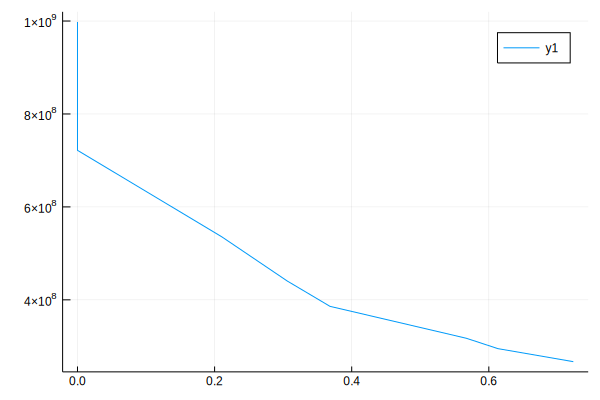

In [31]:
plot(x,y)

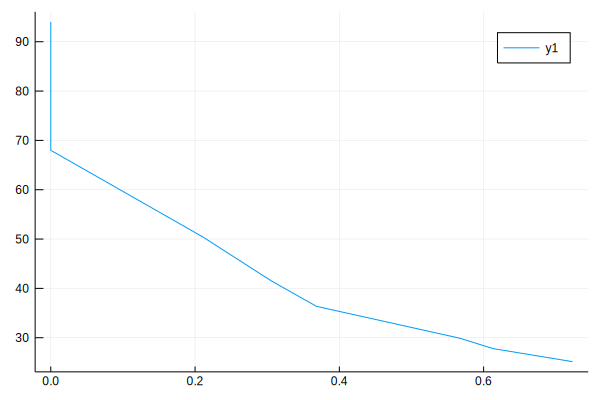

In [32]:
plot(x,y/(365*3*nrow(feature)))

In [37]:
y2 = y/(365*3*nrow(feature));

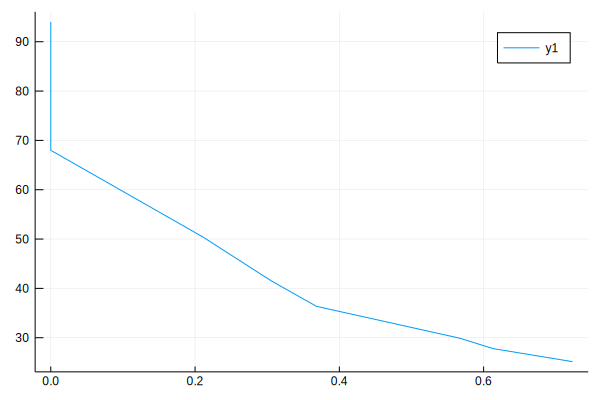

In [35]:
plot(x[1:50],y2[1:50])